In [0]:
# Imports here
import torch
import torch.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, models, transforms
from torchvision import datasets, transforms, models
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import json
import numpy as np
import time
import copy
import matplotlib.pyplot as plt
%matplotlib inline
import os,cv2

import pandas as pd
#from pylab import rcParams
#rcParams['figure.figsize'] = 20, 10

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
data_dir = "./gdrive/My Drive/facial_expressions/img"
#data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
cat_to_name = data_dir + "/cat_to_name.json"
# TODO: Define your transforms for the training and validation sets
data_transforms = {
    'train': transforms.Compose([
        transforms.ColorJitter(brightness=0.2, saturation=.1),
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Resize(240),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
    }

# TODO: Load the datasets with ImageFolder

dirs = {'train': train_dir, 
        'valid': valid_dir,
        'test': data_dir}

datasets = {x: torchvision.datasets.ImageFolder(dirs[x],   transform=data_transforms[x]) for x in ['train', 'valid', 'test']}

# TODO: Using the image datasets and the trainforms, define the dataloaders

dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=22, shuffle=True, num_workers=7) for x in ['train', 'valid','test']}

dataset_sizes = {x: len(datasets[x]) 
                              for x in ['train', 'valid','test']}
print(dataset_sizes)

{'train': 151, 'valid': 63, 'test': 214}


In [0]:
import json

with open(cat_to_name, 'r') as f:
    cat_to_name = json.load(f)
print(cat_to_name) 

{'1': 'ANGRY', '2': 'DISGUST', '3': 'FEAR', '4': 'HAPPY', '5': 'NEUTRAL', '6': 'SAD', '7': 'SURPRISE'}


In [0]:
model = models.densenet161(pretrained=True)

model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

In [0]:
%%time

x, y = next(iter(dataloaders['train']));

CPU times: user 18.2 ms, sys: 458 ms, total: 476 ms
Wall time: 1.32 s


In [0]:
class_names = datasets['train'].classes
print(class_names)

['1', '2', '3', '4', '5', '6', '7']


In [0]:
def train_model(model, criteria, optimizer, scheduler = None, epochs=50, device='cuda'):

    since = time.time()
    best_model = copy.deepcopy(model.state_dict())
    
    # initialize tracker for accuracy 
    best_acc = 0 
    TS_loss = pd.DataFrame(np.nan, index = range(1,epochs+1), columns = ['train loss','valid loss'])
    TS_acc = pd.DataFrame(np.nan,index = range(1,epochs+1), columns = ['train acc','valid acc'])
    
    for epoch in range(1,epochs+1):
        print('Epoch {}/{}'.format(epoch, epochs))
        print('-' * 10)
        
        # monitor loss/accuracy
        train_loss_running = 0.0
        valid_loss_running = 0.0
        train_acc_running = 0.0
        valid_acc_running = 0.0

        ###################
        # train the model #
        ###################
        if scheduler:
            scheduler.step()
        model.train() # prep model for training
        
        for data, target in dataloaders['train']:
    
            # Move input and data tensors to the default device
            data, target = data.to(device), target.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criteria(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss 
            train_loss_running += loss.item()*data.size(0)
            # accuracy
            _, preds = torch.max(output, 1)
            train_acc_running  += torch.sum(preds == target.data)
            
            del loss

        ######################    
        # validate the model #
        ######################
        model.eval()
        with torch.no_grad():
            for data, target in dataloaders['valid']:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criteria(output, target)
                valid_loss_running += loss.item()*data.size(0)
                
                _, preds = torch.max(output, 1)
                valid_acc_running  += torch.sum(preds == target.data)
                
                del loss
                # Calculate accuracy
                #ps = torch.exp(logps)
                #top_p, top_class = ps.topk(1, dim=1)
                #equals = top_class == labels.view(*top_class.shape)
                #accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        # statistics
        train_loss = train_loss_running/ dataset_sizes['train']
        valid_loss = valid_loss_running/ dataset_sizes['valid']
        train_acc = train_acc_running.double()/ dataset_sizes['train']
        valid_acc = valid_acc_running.double()/ dataset_sizes['valid']
        
        TS_loss.loc[epoch] = [train_loss, valid_loss]
        TS_acc.loc[epoch] = [(train_acc.cpu().numpy()), (valid_acc.cpu().numpy())]                                         

        # print training/validation statistics 
        print('Train - Loss: {:.4f} Acc: {:.4f}'.format(train_loss, train_acc))
        print('Valid - Loss: {:.4f} Acc: {:.4f}'.format(valid_loss, valid_acc))                                                 
                                                             
        # save model if validation acc has increased
        if valid_acc > best_acc:
            print('Validation Acc increased ({:.4f} --> {:.4f}).  Saving model.'.format(best_acc,valid_acc))
            best_model = copy.deepcopy(model.state_dict())                                                                    
            best_acc = valid_acc
        
        print()
    
    #End
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Valid Acc: {:4f}'.format(best_acc))
                                                   
    TS_loss.plot(title = 'loss')
    TS_acc.plot(title = 'acc')
                                                   
    # load best model weights
    model.load_state_dict(best_model)
    torch.save(model.state_dict(), 'model.pt')
    
    return model

Epoch 1/30
----------
Train - Loss: 3.3816 Acc: 0.1722
Valid - Loss: 2.7231 Acc: 0.2540
Validation Acc increased (0.0000 --> 0.2540).  Saving model.

Epoch 2/30
----------
Train - Loss: 2.3772 Acc: 0.2980
Valid - Loss: 2.7723 Acc: 0.2540

Epoch 3/30
----------
Train - Loss: 2.0033 Acc: 0.2848
Valid - Loss: 2.6419 Acc: 0.3016
Validation Acc increased (0.2540 --> 0.3016).  Saving model.

Epoch 4/30
----------
Train - Loss: 1.8763 Acc: 0.3510
Valid - Loss: 2.1715 Acc: 0.2540

Epoch 5/30
----------
Train - Loss: 1.6107 Acc: 0.3179
Valid - Loss: 1.8997 Acc: 0.3016

Epoch 6/30
----------
Train - Loss: 1.4272 Acc: 0.4834
Valid - Loss: 1.7703 Acc: 0.3492
Validation Acc increased (0.3016 --> 0.3492).  Saving model.

Epoch 7/30
----------
Train - Loss: 1.5048 Acc: 0.3907
Valid - Loss: 1.7358 Acc: 0.3492

Epoch 8/30
----------
Train - Loss: 1.5026 Acc: 0.4238
Valid - Loss: 1.7518 Acc: 0.3333

Epoch 9/30
----------
Train - Loss: 1.3786 Acc: 0.4967
Valid - Loss: 1.7197 Acc: 0.3492

Epoch 10/30
----

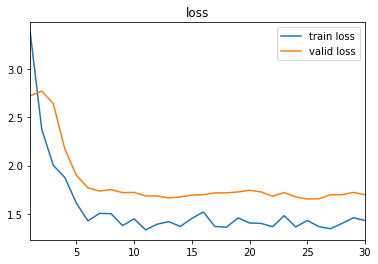

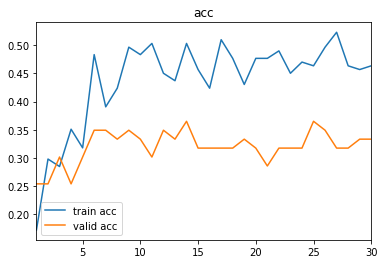

In [0]:
epochs = 30
# freezing the feature part of the pre-trained model 
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Linear(model.classifier.in_features, len(class_names))
model.fc =  nn.Sequential(
         nn.Linear(2208, 1000),
         nn.ReLU(),
         nn.Linear(1000, len(class_names)))


criteria = nn.CrossEntropyLoss()    
    
optimizer = optim.Adam(model.parameters(), lr=1e-2)


scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

model_ft = train_model(model, criteria, optimizer, scheduler, epochs, device)

In [0]:
modely = models.densenet161(pretrained=False)
modely.classifier = nn.Linear(model_ft.classifier.in_features, len(class_names))
modely.load_state_dict(torch.load('model.pt'),strict=False)

IncompatibleKeys(missing_keys=[], unexpected_keys=['fc.0.weight', 'fc.0.bias', 'fc.2.weight', 'fc.2.bias'])

In [0]:
print(modely)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

Epoch 1/65
----------
Train - Loss: 1.4050 Acc: 0.5232
Valid - Loss: 1.5917 Acc: 0.3810
Validation Acc increased (0.0000 --> 0.3810).  Saving model.

Epoch 2/65
----------
Train - Loss: 1.3943 Acc: 0.4570
Valid - Loss: 1.5537 Acc: 0.4127
Validation Acc increased (0.3810 --> 0.4127).  Saving model.

Epoch 3/65
----------
Train - Loss: 1.3094 Acc: 0.5497
Valid - Loss: 1.4901 Acc: 0.4444
Validation Acc increased (0.4127 --> 0.4444).  Saving model.

Epoch 4/65
----------
Train - Loss: 1.2759 Acc: 0.5695
Valid - Loss: 1.4391 Acc: 0.4444

Epoch 5/65
----------
Train - Loss: 1.3686 Acc: 0.4768
Valid - Loss: 1.4438 Acc: 0.4127

Epoch 6/65
----------
Train - Loss: 1.2965 Acc: 0.5298
Valid - Loss: 1.4360 Acc: 0.4444

Epoch 7/65
----------
Train - Loss: 1.1386 Acc: 0.6225
Valid - Loss: 1.4381 Acc: 0.4286

Epoch 8/65
----------
Train - Loss: 1.2744 Acc: 0.5430
Valid - Loss: 1.4523 Acc: 0.4444

Epoch 9/65
----------
Train - Loss: 1.1922 Acc: 0.6093
Valid - Loss: 1.4123 Acc: 0.4603
Validation Acc in

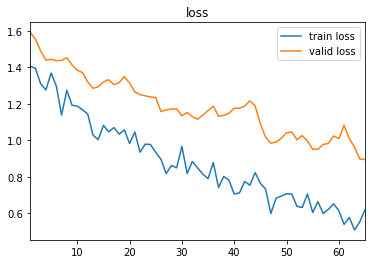

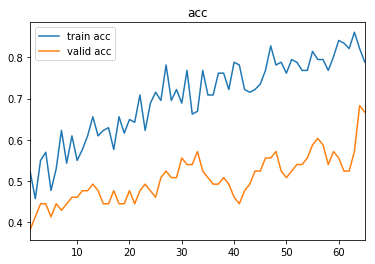

In [0]:
for param in model_ft.parameters():
    param.requires_grad = True

criteria = nn.CrossEntropyLoss()    
    
optimizer = optim.Adam(model_ft.parameters(), lr=1e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft.to(device);

epochs = 65

modelxy = train_model(model_ft, criteria, optimizer,None, epochs, device)

In [0]:
# save model as a checkpoint file 
def save_model_checkpoint(model, optimizer, criteria, epochs):
  model.to('cpu')
  model.class_to_idx = datasets['train'].class_to_idx
  checkpoint = {'input_size': 224*224*3,
                'output_size': 7,
                'model': model,
                'state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'criterion': criteria,
                'epochs': epochs,
                'class_to_idx': model.class_to_idx}

  path = "/content/gdrive/My Drive/facial_expressions/facial_expressions.pth"
  torch.save(checkpoint,path)


# load model function 
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath, map_location='cpu')
    model = checkpoint["model"]
    model.load_state_dict(checkpoint['state_dict'])
    return model


In [0]:
save_model_checkpoint(modelxy, optimizer, criteria, epochs)